In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,classification_report
import warnings
warnings.filterwarnings("ignore")
data0 = pd.read_csv('dataset.csv')
print(data0.isnull().sum())

island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
sex                  10
species               0
body_mass_g           2
dtype: int64


In [2]:
# (1)数据预处理，检查数据，找出sex值为.的行并进行替换
sexPoint = data0.iloc[::][data0.sex=='.']
print(sexPoint)
data0.replace('.','MALE',inplace=True)

     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm sex species  \
336  Biscoe              44.5             15.7              217.0   .  Gentoo   

     body_mass_g  
336       4875.0  


In [3]:
# 数据清洗：对连续变量的缺失值用均值填补，离散型变量的缺失值用众数填补
mean_val = data0['culmen_length_mm'].mean()
data0['culmen_length_mm'] = data0['culmen_length_mm'].fillna(mean_val)
mean_val = data0['culmen_depth_mm'].mean()
data0['culmen_depth_mm'] = data0['culmen_depth_mm'].fillna(mean_val)
mean_val = data0['flipper_length_mm'].mean()
data0['flipper_length_mm'] = data0['flipper_length_mm'].fillna(mean_val)
mean_val = data0['body_mass_g'].mean()
data0['body_mass_g'] = data0['body_mass_g'].fillna(mean_val)
freq_port = data0.sex.dropna().mode()[0]
data0['sex'] = data0['sex'].fillna(freq_port)
print(data0.isnull().sum())

island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
sex                  0
species              0
body_mass_g          0
dtype: int64


In [4]:
# 采用独热编码对离散型变量进行编码
data = pd.get_dummies(data0, columns=["island", "sex", "species"])

In [5]:
# (2) 探索性分析并分割训练-测试集
X = data.drop(columns=["species_Adelie", "species_Chinstrap", "species_Gentoo", "body_mass_g"])
y_species = data[["species_Adelie", "species_Chinstrap", "species_Gentoo"]]
y_body_mass = data["body_mass_g"]

X_train, X_test, y_species_train, y_species_test, y_body_mass_train, y_body_mass_test = train_test_split(
    X, y_species, y_body_mass, test_size=0.2, random_state=50)

# 采用10折交叉检验
kf = KFold(n_splits=10, shuffle=True, random_state=25)
accuracys = []
adelie_precisions = []
adelie_recalls = []
mses = []
maes = []
r2s = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_species_train, y_species_test = y_species.iloc[train_index], y_species.iloc[test_index]
    y_body_mass_train, y_body_mass_test = y_body_mass.iloc[train_index], y_body_mass.iloc[test_index]
    
    # 特征缩放
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_body_mass_train = scaler.fit_transform(y_body_mass_train.values.reshape(-1, 1))
    y_body_mass_test = scaler.fit_transform(y_body_mass_test.values.reshape(-1, 1))
    
# (3) species的分类模型
    species_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    species_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    
    species_model.fit(X_train, y_species_train, epochs=50, batch_size=10, verbose=0)

    # 评估分类模型
    species_predictions = species_model.predict(X_test)
    species_predictions = np.argmax(species_predictions, axis=1)
    y_species_test = np.argmax(np.array(y_species_test), axis=1)
    class_report = classification_report(y_species_test, species_predictions, output_dict=True)   
    adelie_precision = class_report['0']['precision'] # Assuming Adelie is encoded as 0
    adelie_recall = class_report['0']['recall']
    accuracy = sum(species_predictions == y_species_test) / len(y_species_test)
    adelie_precisions.append(adelie_precision)
    adelie_recalls.append(adelie_recall)
    accuracys.append(accuracy)
    print("分类模型准确率: {:.2f}%".format(accuracy * 100))
    print("Adelie标签的精确率: {:.2f}%".format(adelie_precision * 100))
    print("Adelie标签的召回率: {:.2f}%".format(adelie_recall * 100))
    
# (4) body_mass_g的回归模型
    body_mass_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    # 评估回归模型
    body_mass_model.compile(optimizer='adam', loss='mean_squared_error')
    body_mass_model.fit(X_train, y_body_mass_train, epochs=500, batch_size=10, verbose=0)
    body_mass_predictions = body_mass_model.predict(X_test).flatten()
    mse = mean_squared_error(y_body_mass_test, body_mass_predictions)
    mae = mean_absolute_error(y_body_mass_test, body_mass_predictions)
    r2 = r2_score(y_body_mass_test, body_mass_predictions)
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")

2/2 [==============================] - 0s 3ms/step
分类模型准确率: 100.00%
Adelie标签的精确率: 100.00%
Adelie标签的召回率: 100.00%
2/2 [==============================] - 0s 3ms/step
Mean Squared Error: 0.26166561049358306
Mean Absolute Error: 0.41526213802055434
R2 Score: 0.7383343895064169
2/2 [==============================] - 0s 2ms/step
分类模型准确率: 97.14%
Adelie标签的精确率: 100.00%
Adelie标签的召回率: 93.33%
2/2 [==============================] - 0s 3ms/step
Mean Squared Error: 0.15449321065288338
Mean Absolute Error: 0.3182230640824905
R2 Score: 0.8455067893471166
2/2 [==============================] - 0s 2ms/step
分类模型准确率: 100.00%
Adelie标签的精确率: 100.00%
Adelie标签的召回率: 100.00%
2/2 [==============================] - 0s 2ms/step
Mean Squared Error: 0.17618377931484186
Mean Absolute Error: 0.351905275387057
R2 Score: 0.8238162206851581
2/2 [==============================] - 0s 2ms/step
分类模型准确率: 97.14%
Adelie标签的精确率: 100.00%
Adelie标签的召回率: 94.44%
2/2 [==============================] - 0s 3ms/step
Mean Squared Error: 0.370

Best fold index for Classification: 0
Adelie Precision in best fold: 1.0
Adelie Recall in best fold: 1.0


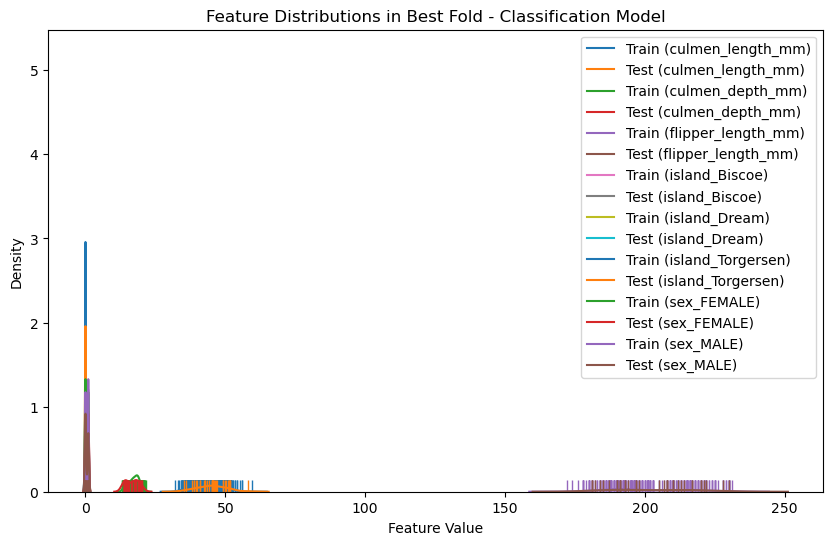

Best fold index for Regression: 5
Mean Squared Error in best fold: 0.11576090947746094
Mean Absolute Error in best fold: 0.27337017341426184
R2 Score in best fold: 0.884239090522539


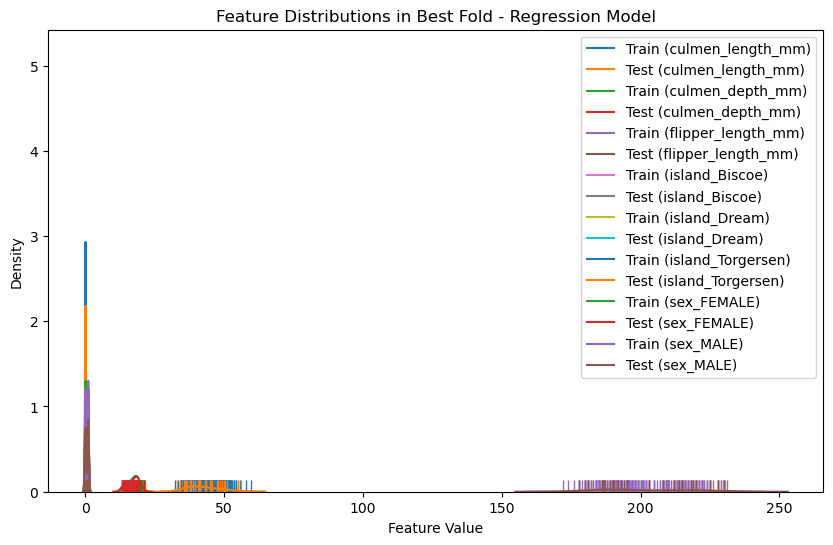

In [6]:
# 找出性能最佳的折
best_classification_fold_index = np.argmax(adelie_recall)  # 假设以Adelie的精确度为准
best_fold_index = np.argmax(adelie_recall)
print(f"Best fold index for Classification: {best_fold_index}")
print(f"Adelie Precision in best fold: {adelie_precisions[best_fold_index]}")
print(f"Adelie Recall in best fold: {adelie_recalls[best_fold_index]}")
# 使用性能最佳的折索引重新划分数据
train_index, test_index = list(kf.split(X))[best_classification_fold_index]
X_train_classification, X_test_classification = X.iloc[train_index], X.iloc[test_index]
y_species_train_classification, y_species_test_classification = y_species.iloc[train_index], y_species.iloc[test_index]
# 可视化特征分布
plt.figure(figsize=(10, 6))
for feature in X.columns:
    sns.distplot(X_train_classification[feature], hist=False, rug=True, label=f"Train ({feature})")
    sns.distplot(X_test_classification[feature], hist=False, rug=True, label=f"Test ({feature})")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.title("Feature Distributions in Best Fold - Classification Model")
plt.legend()
plt.show()

# 找出性能最佳的折 - 回归模型
best_regression_fold_index = np.argmax(r2s)  # 以R²分数为准
best_fold_index = np.argmax(r2s) # 以R²分数为例
print(f"Best fold index for Regression: {best_fold_index}")
print(f"Mean Squared Error in best fold: {mses[best_fold_index]}")
print(f"Mean Absolute Error in best fold: {maes[best_fold_index]}")
print(f"R2 Score in best fold: {r2s[best_fold_index]}")
# 使用性能最佳的折索引重新划分数据
train_index, test_index = list(kf.split(X))[best_regression_fold_index]
X_train_regression, X_test_regression = X.iloc[train_index], X.iloc[test_index]
y_body_mass_train_regression, y_body_mass_test_regression = y_body_mass.iloc[train_index], y_body_mass.iloc[test_index]
# 可视化特征分布 
plt.figure(figsize=(10, 6))
for feature in X.columns:
    sns.distplot(X_train_regression[feature], hist=False, rug=True, label=f"Train ({feature})")
    sns.distplot(X_test_regression[feature], hist=False, rug=True, label=f"Test ({feature})")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.title("Feature Distributions in Best Fold - Regression Model")
plt.legend()
plt.show()

<AxesSubplot: >

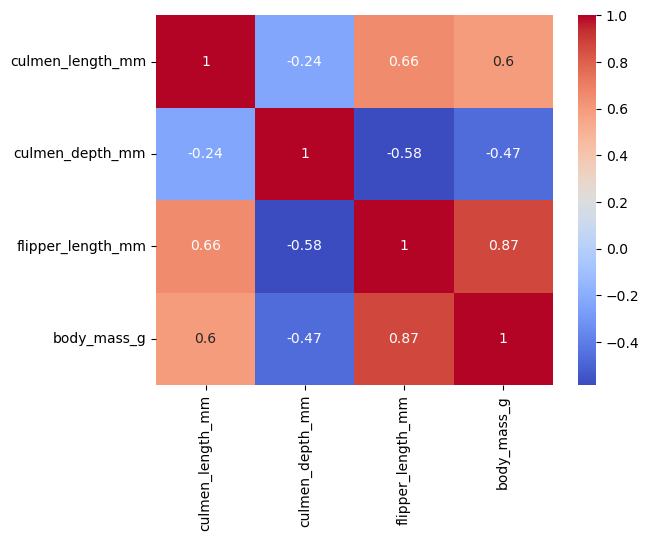

In [8]:
# 使用皮尔森计算特征相关矩阵
corr = data0.corr(method='pearson') 
# 热力图绘制相关性矩阵
sns.heatmap(data=corr, annot=True, cmap='Blues')

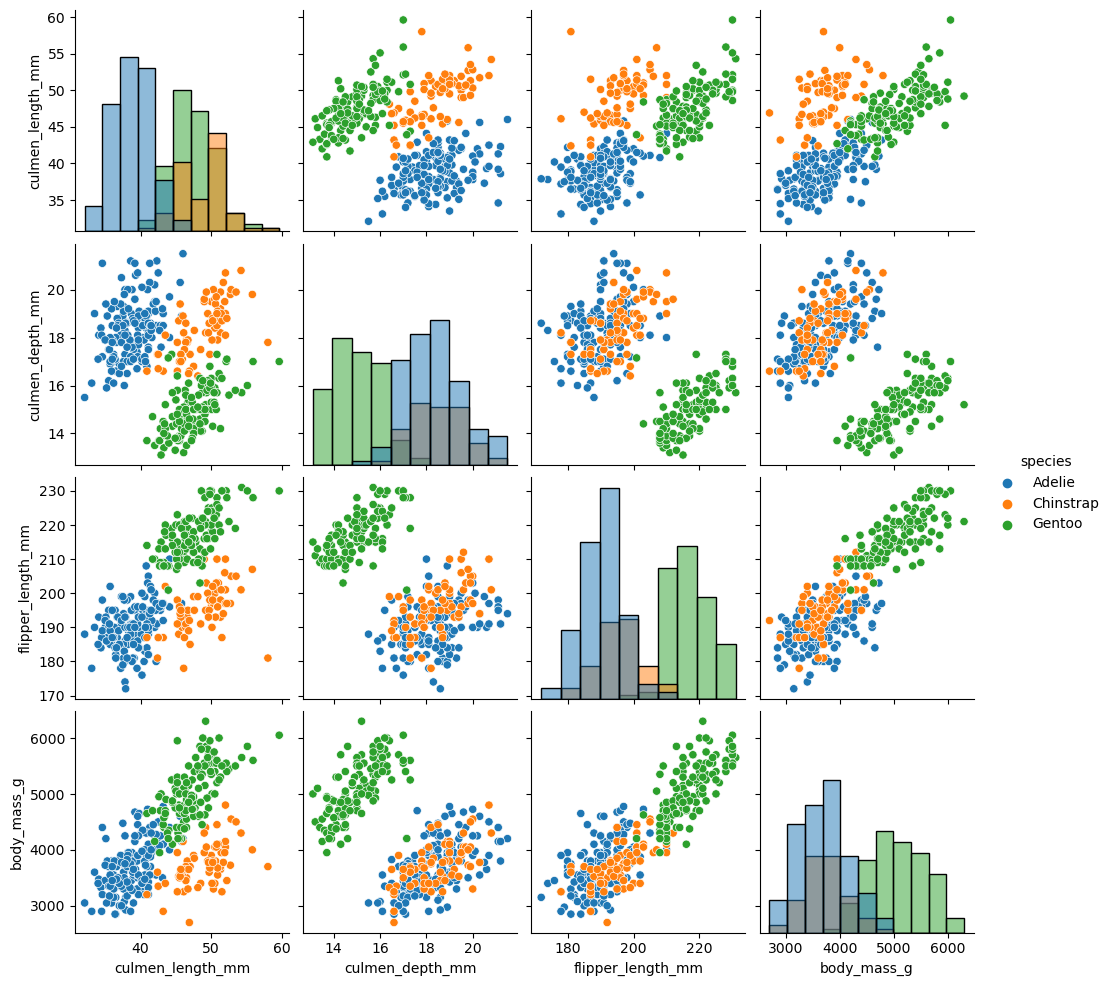

In [10]:
sns.pairplot(data=data0, diag_kind='hist', hue= 'species')
plt.show()